In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.metrics import precision_score, recall_score, accuracy_score, classification_report, roc_curve, precision_recall_curve, confusion_matrix, f1_score, average_precision_score, cohen_kappa_score
from inspect import signature
from sklearn.externals import joblib
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

C:\Users\Pappa\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


# 1. Prepare Data

In [2]:
X_train_resampled = pd.read_csv("../3. Data Preparation/X_train_resampled.csv", index_col=0)
X_train_resampled.shape

(1848, 30)

In [3]:
y_train_resampled = pd.read_csv("../3. Data Preparation/y_train_resampled.csv", index_col=0)
y_train_resampled.shape

(1848, 1)

In [4]:
X_val = pd.read_csv("../3. Data Preparation/X_val.csv", index_col=0)
X_val.shape

(56962, 30)

In [5]:
y_val = pd.read_csv("../3. Data Preparation/y_val.csv", index_col=0, header=0)
y_val.shape

(56962, 1)

In [6]:
OOB_4= pd.read_csv("XGB (AllFeatures - OOB - 4).csv", index_col=0)
OOB_4.shape

(4, 1)

In [7]:
target_names=['Not Fraud 0', 'Fraud 1']

In [8]:
from sklearn.metrics import confusion_matrix

import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


np.set_printoptions(precision=2)


## 2. XGBoost Classifier with OOB Score equal to 4

In [9]:
xgb_clf = xgb.XGBClassifier(n_jobs=-1, n_estimators=300)

In [10]:
xgb_clf.fit(X_train_resampled[OOB_4.index.values].copy(), y_train_resampled['Class'].values)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=300, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [11]:
y_pred = xgb_clf.predict(X_val[OOB_4.index.values])

In [12]:
y_score = xgb_clf.predict_proba(X_val[OOB_4.index.values])[:,1]

# 3. Features Importance

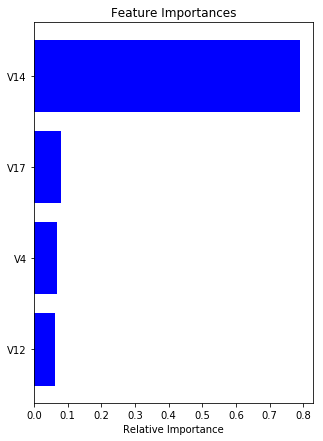

In [13]:
features = X_train_resampled[OOB_4.index.values].columns
importances = xgb_clf.feature_importances_
indices = np.argsort(importances)
fig, ax = plt.subplots(figsize=(5, 7))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.savefig('XGBoost OOB 4.png')
plt.show()

## 4. Confusion Matrix

Confusion matrix, without normalization
[[56297   568]
 [   11    86]]


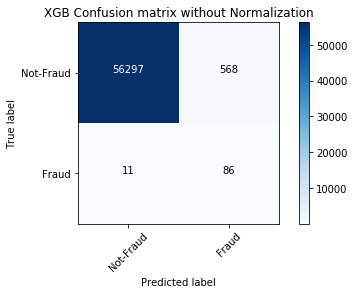

Normalized confusion matrix
[[0.99 0.01]
 [0.11 0.89]]


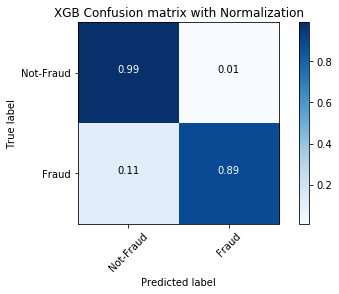

In [15]:
cm = confusion_matrix(y_val['Class'].values, y_pred)

class_names = ['Not-Fraud','Fraud']
plt.figure()
plot_confusion_matrix(cm, 
                      classes = class_names , 
                      title = 'XGB Confusion matrix without Normalization')
plt.show()

plot_confusion_matrix(cm, 
                      classes = class_names , 
                      normalize = True,
                      title = 'XGB Confusion matrix with Normalization')
plt.show()


# 5. Metrics Scores

In [15]:
print(classification_report(y_val['Class'].values, y_pred, target_names=target_names))

              precision    recall  f1-score   support

 Not Fraud 0       1.00      0.99      0.99     56865
     Fraud 1       0.13      0.89      0.23        97

    accuracy                           0.99     56962
   macro avg       0.57      0.94      0.61     56962
weighted avg       1.00      0.99      0.99     56962



In [16]:
total1=sum(sum(cm))


sensitivity1 = cm[0,0]/(cm[0,0]+cm[0,1])
print('Sensitivity : ', sensitivity1 )

specificity1 = cm[1,1]/(cm[1,0]+cm[1,1])
print('Specificity : ', specificity1)

Sensitivity :  0.9900114305812011
Specificity :  0.8865979381443299


In [17]:

acc= accuracy_score( y_val['Class'].values, y_pred)
recall = recall_score(y_val['Class'].values, y_pred, average='binary')
precision = precision_score( y_val['Class'].values, y_pred)
f1 = f1_score( y_val['Class'].values, y_pred, average='binary')
average = average_precision_score( y_val['Class'].values, y_pred)
kappa = cohen_kappa_score( y_val['Class'].values, y_pred)

print('Accuracy', acc)
print('Recall score', recall)
print('Precision', precision)
print('f1_score', f1)
print ('Average precision-recall score: {0:0.2f}'.format(average))
print('Kappa Score', kappa)

Accuracy 0.9898353288157017
Recall score 0.8865979381443299
Precision 0.13149847094801223
f1_score 0.22902796271637815
Average precision-recall score: 0.12
Kappa Score 0.22673454628392942


##  6. Save Scores 

In [18]:
result = pd.read_csv("../Results/model_Result_final.csv", index_col=0)

In [19]:
model_Results = pd.DataFrame([['XGB with OOB4', acc, precision, recall, f1, average, kappa, specificity1, sensitivity1]],
               columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'Average', 'Kappa Cohen', 'Specificity', 'Sensitivity'])

In [20]:
result.columns

Index(['Accuracy', 'Average', 'F1 Score', 'Kappa Cohen', 'Model', 'Precision',
       'Recall', 'Sensitivity', 'Specificity'],
      dtype='object')

In [21]:
x = result.append(model_Results, ignore_index=True)

In [22]:
x

,Accuracy,Average,F1 Score,Kappa Cohen,Model,Precision,Recall,Sensitivity,Specificity
0,0.996647,0.277870,0.467967,0.466641,Random Forest All Features,0.320611,0.865979,0.996870,0.865979
1,0.993908,0.174253,0.326214,0.324346,Random Forest (n=27) with OOB_9,0.200957,0.865979,0.994126,0.865979
2,0.995225,0.219926,0.387387,0.385752,Random Forest (n=35) with OOB_12,0.247839,0.886598,0.995410,0.886598
3,0.993241,0.159751,0.303797,0.301837,AdaBoost Simple Classifier,0.184211,0.865979,0.993458,0.865979
4,0.993206,0.155993,0.300181,0.298210,AdaBoost (n=15) with OOB_10,0.182018,0.855670,0.993441,0.855670
5,0.994347,0.188779,0.345528,0.343734,XGBoost Classifier,0.215190,0.876289,0.994548,0.876289
6,0.994382,0.169188,0.330544,0.328722,XGBoost Classifier Parameter Tuning,0.207349,0.814433,0.995076,0.886598
7,0.989835,0.116779,0.229028,0.226735,XGB with OOB4,0.131498,0.886598,0.990011,0.886598


Text(0.5,1,'Precision-Recall curve: AP=0.12')

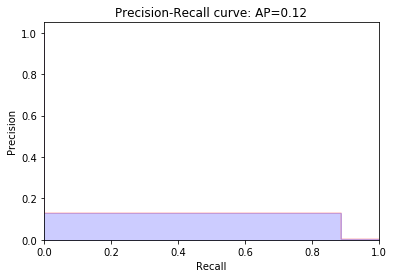

In [23]:
# plot precision-recall score


precision, recall, _ = precision_recall_curve( y_val['Class'].values, y_pred)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='r', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: AP={0:0.2f}'.format(
          average))

In [24]:
def plot_roc():
    plt.plot(fpr, tpr, label = 'ROC curve' , linewidth = 2, color= 'darkorange')
    plt.plot([0,1],[0,1], 'k--', linewidth = 2, color ='navy', linestyle='--')
    plt.xlim([0.0,0.001])
    plt.ylim([0.0,1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show();

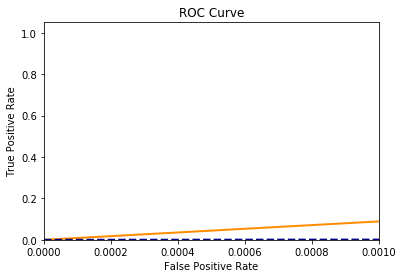

In [25]:
fpr, tpr, t = roc_curve( y_val['Class'].values, y_pred)
plot_roc()

In [26]:
x.to_csv("../Results/model_Result_final.csv")

## 7. Save Model

In [27]:
joblib.dump(xgb_clf, 'XGBoostwithOOB4.pkl') 

['XGBoostwithOOB4.pkl']